# Herpeton Project - Combined Notebook

This is an attempt to bring `notebook.ipynb` and `preprocess_bug_fix.ipynb` into a unified state for simpler working.



# Step 1: Environment Setup and Compatibility Checks

Initial runs of the notebook generated PyArrow issues so we added this to resolve if needed. It may simply run and complete sucessfully.

In [1]:
# Install and address any PyArrow compatibility issues
import subprocess
import sys
import importlib

def check_and_fix_pyarrow():
    """Check PyArrow version and fix compatibility issues"""
    print("Checking PyArrow compatibility")

    try:
        import pyarrow as pa
        print(f"PyArrow version: {pa.__version__}")

        # Test for the extension type attribute
        if hasattr(pa.lib, 'PyExtensionType'):
            print("PyExtensionType is available")
            return True
        else:
            print("PyExtensionType not found - version issue detected")
            return False

    except ImportError:
        print("PyArrow not installed")
        return False

def fix_pyarrow_compatibility():
    """Fix PyArrow version compatibility"""
    print("\nFixing PyArrow compatibility")

    try:
        # Uninstall and reinstall with specific compatible versions if needed
        print("Uninstalling existing PyArrow")
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "pyarrow"])

        print("Installing compatible PyArrow version")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyarrow>=12.0.0,<15.0.0"])

        # Ensure pandas compatibility
        print("Updating pandas for compatibility")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pandas>=1.5.0"])

        print("PyArrow compatibility fix complete.")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Failed to fix PyArrow: {e}")
        return False

def install_package(package_name, import_name=None):
    """Install a package and verify it can be imported"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        importlib.import_module(import_name)
        print(f"{package_name} is already installed")
        return True
    except ImportError:
        print(f"Installing {package_name}")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"{package_name} installed successfully")
            return True
        except subprocess.CalledProcessError as e:
            print(f"Failed to install {package_name}: {e}")
            return False

print("Setting up BioTrove Reptilia processing environment")
print("=" * 60)

# Check and fix PyArrow if needed
if not check_and_fix_pyarrow():
    print("\nAttempting to fix PyArrow compatibility")
    if fix_pyarrow_compatibility():
        # Re-check after fix
        if check_and_fix_pyarrow():
            print("PyArrow issue resolved.")
        else:
            print("WARNING: PyArrow issue persists")
    else:
        print("ERROR: Could not automatically fix PyArrow")

print("\n" + "=" * 60)

# List of required packages (with specific versions to avoid conflicts)
required_packages = [
    ("arbor-process", "arbor_process"),
    ("nest_asyncio", "nest_asyncio"),
    ("datasets>=2.14.0", "datasets"),
    ("pandas>=1.5.0", "pandas"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("pillow", "PIL"),
    ("requests", "requests"),
    ("tqdm", "tqdm"),
    ("python-dotenv", "dotenv"),
    ("huggingface_hub", "huggingface_hub"),
    ("webdataset", "webdataset")
]

# Install packages
all_installed = True
for package_name, import_name in required_packages:
    if not install_package(package_name, import_name):
        all_installed = False

if all_installed:
    print("\nAll packages installed successfully")
    print("Ready to process BioTrove Reptilia dataset")
else:
    print("\nWARNING: Some packages failed to install")
    print("You may need to install them manually")

print("\nNOTE: If PyArrow errors persist, try:")
print("   pip install --force-reinstall pyarrow==14.0.2")
print("   pip install --force-reinstall pandas==2.0.3")

print("\n" + "=" * 60)

Setting up BioTrove Reptilia processing environment
Checking PyArrow compatibility
PyArrow version: 16.1.0
PyExtensionType is available

arbor-process is already installed
nest_asyncio is already installed
datasets>=2.14.0 is already installed
pandas>=1.5.0 is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
pillow is already installed
requests is already installed
tqdm is already installed
python-dotenv is already installed
huggingface_hub is already installed
Installing webdataset
webdataset installed successfully

All packages installed successfully
Ready to process BioTrove Reptilia dataset

NOTE: If PyArrow errors persist, try:
   pip install --force-reinstall pyarrow==14.0.2
   pip install --force-reinstall pandas==2.0.3



# Step 2: Import Required Libraries

Import all necessary libraries for the BioTrove processing pipeline.

In [2]:
# Core imports
import os
import random
import shutil
import time
import json
import pandas as pd
import numpy as np
import webdataset as wds
import math
from pathlib import Path
from dotenv import load_dotenv
from tqdm import tqdm

# HuggingFace and BioTrove tools
from huggingface_hub import snapshot_download
from arbor_process import MetadataProcessor, GenShuffledChunks, GetImages, GenImgTxtPair

# For async operations
import nest_asyncio
nest_asyncio.apply()

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries imported successfully.")

All libraries imported successfully.


# Step 3: Environment Configuration

Load environment variables and configure HuggingFace authentication.

In [ ]:
#@title Fetch HF token from .env
load_dotenv()

hf_token = os.getenv("HF_TOKEN") # This expects an .env file with HF_TOKEN variable and the .env file is identitifed in the .gitignore file.

# Check if HF token is available
if hf_token is None:
    print("WARNING: HF_TOKEN not found in environment variables.")

else:
    print("HuggingFace token loaded successfully")

In [3]:
#@title fetch HF token from Colab Secrets
from google.colab import userdata
from huggingface_hub import login

# Get the token from Colab secrets
hf_token = userdata.get('HF_TOKEN')

if hf_token:
    # Log in to the Hugging Face Hub
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("HF_TOKEN not found in Colab secrets. Please add it via the Secrets tab.")

# You can now proceed with actions that require authentication,
# such as downloading private models or pushing to the Hub.


Successfully logged in to Hugging Face!


# Step 4: Configure Directory Structure

Set up the directory structure for data processing.

In [5]:
#@title Mount Google Drive
CURATE_TO_DRIVE = True

if CURATE_TO_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_OUT = "/content/drive/MyDrive/herpeton/data/biotrove_train"
else:
    BASE_OUT = "/content/herpeton"

os.makedirs(BASE_OUT, exist_ok=True)

REPORT_DIR = os.path.join(BASE_OUT, "_reports")
os.makedirs(REPORT_DIR, exist_ok=True)

print(f"Output base: {BASE_OUT}")
print(f"Reports   : {REPORT_DIR}")


Mounted at /content/drive
Output base: /content/drive/MyDrive/herpeton/data/biotrove_train
Reports   : /content/drive/MyDrive/herpeton/data/biotrove_train/_reports


In [6]:
#@title Configure all data paths
DATA_ROOT = Path("/content/drive/MyDrive/herpeton/data/biotrove_train")
META_DIR = DATA_ROOT / "raw_metadata"
PARAQUETS_PATH = META_DIR / "BioTrove-Train"
OUT_DIR = DATA_ROOT / "processed_metadata"
FILTERED_OUT = DATA_ROOT / "filtered_reptilia"
INPUT_PARQUETS = FILTERED_OUT / "merged_cases"
IMG_DIR = DATA_ROOT / "images_reptilia"
SPLITS_CSV = DATA_ROOT / "reptilia_tar_splits.csv"
COUNTS = DATA_ROOT / "processed_metadata" / "combined_sample_counts_per_species.csv"

# Create directories
META_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
INPUT_PARQUETS.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

print("Directory structure created:")
print(f"  Data root: {DATA_ROOT}")
print(f"  Metadata: {META_DIR}")
print(f"  Processed: {OUT_DIR}")
print(f"  Images: {IMG_DIR}")

Directory structure created:
  Data root: /content/drive/MyDrive/herpeton/data/biotrove_train
  Metadata: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata
  Processed: /content/drive/MyDrive/herpeton/data/biotrove_train/processed_metadata
  Images: /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia


# Step 5: Download BioTrove Metadata

Download metadata from HuggingFace (parquet files only).

In [ ]:
# Download the biotrove-train metadata from huggingface
print("Downloading BioTrove metadata from HuggingFace")
print("=" * 60)

snapshot_download(
    repo_id="BGLab/BioTrove-Train",
    repo_type="dataset",
    local_dir=str(META_DIR),
    # Only download parquet files
    allow_patterns=["BioTrove-Train/*.parquet"],
)

print("\nMetadata download complete")

# Check downloaded files
parquet_files = list(PARAQUETS_PATH.glob("*.parquet"))
print(f"Downloaded {len(parquet_files)} parquet files")

Fetching 2692 files:   0%|          | 0/2692 [00:00<?, ?it/s]


Metadata download complete
Downloaded 0 parquet files


# Step 6: Process Metadata with MetadataProcessor

Use the official BioTrove MetadataProcessor to extract Reptilia samples.

Processing parquet files with MetadataProcessor
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2522.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2527.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2525.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2526.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2524.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_250.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2529.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2510.parquet
Processed file: /content/drive/My

/usr/local/lib/python3.12/dist-packages/arbor_process/metadata_processor.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['category'] = df_filtered.apply(


Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2618.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2621.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2616.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_26.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2619.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2622.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2617.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/BioTrove-Train/chunk_2599.parquet
Processed file: /content/drive/MyDrive/herpeton/data/biotrove_train/raw_metadata/B

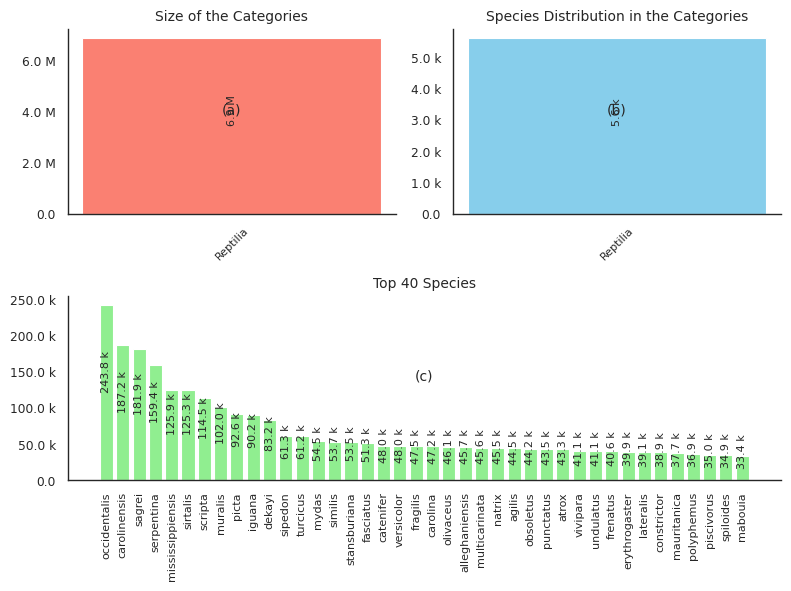

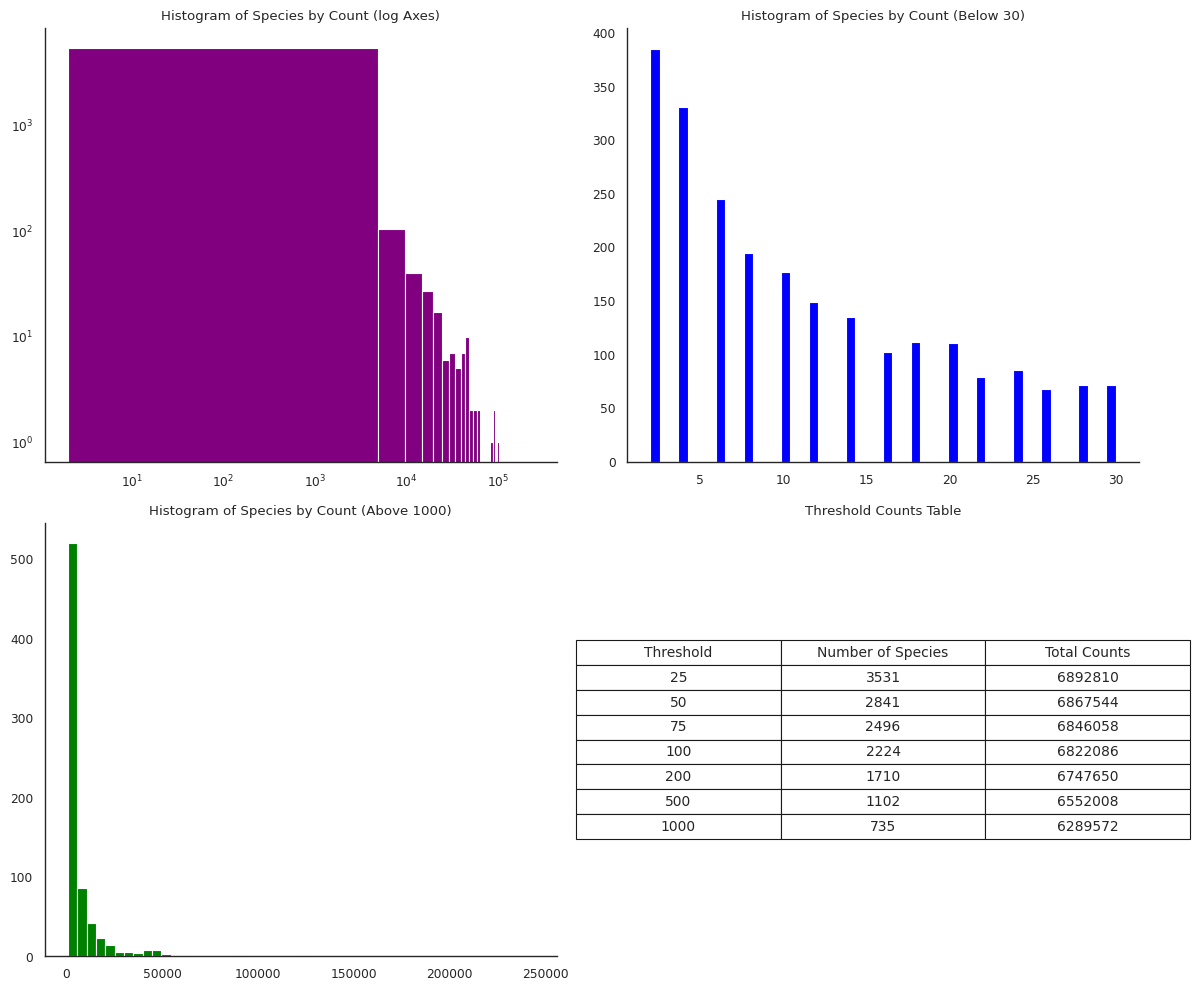

In [ ]:
# Process the parquet files into csvs
print("Processing parquet files with MetadataProcessor")
print("=" * 60)

mp = MetadataProcessor(
    source_folder=str(PARAQUETS_PATH),
    destination_folder=str(OUT_DIR),
    categories=["Reptilia"],
)
mp.process_all_files()

print("\nMetadata processing complete")

# Step 7: GenShuffledChunks Override

In [ ]:
# Generate shuffled chunks with filtering
# This filters the parquet read method to remove any non-reptilia data for efficient processing for our usage.

class GenShuffledChunksReptilia(GenShuffledChunks):
    def process_files(self):
        """
        Process files based on configuration parameters. Filters rare cases,
        caps frequent cases, and shuffles the data into specified parts.
        """
        start_time = time.time()

        final_counts = pd.read_csv(self.species_count_data)
        rare_case = set(final_counts[final_counts['count'] < self.rare_threshold]['species'])
        frequent_case = set(final_counts[final_counts['count'] > self.cap_threshold]['species'])

        for dir_path in [self.rare_dir, self.cap_filtered_dir_train, self.capped_dir, self.merged_dir]:
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)
            os.makedirs(dir_path, exist_ok=True)

        frequent_counts = {}
        capped_cases = []
        files = [f for f in os.listdir(self.directory) if f.endswith(".parquet")]

        for filename in tqdm(files, desc="Processing files"):
            filepath = os.path.join(self.directory, filename)
            # KEY FIX: Add filter to only read Reptilia class
            df = pd.read_parquet(filepath, filters=[("class", "==", "Reptilia")]).dropna()

            rare_df = df[df['species'].isin(rare_case)]
            capped_filtered_df = df[~df['species'].isin(rare_case)]

            rare_df.to_parquet(os.path.join(self.rare_dir, filename), index=False)

            frequent_df = capped_filtered_df[capped_filtered_df['species'].isin(frequent_case)]
            frequent_case_counts = frequent_df['species'].value_counts().to_dict()

            for case, count in frequent_case_counts.items():
                frequent_counts[case] = frequent_counts.get(case, 0) + count
                if frequent_counts[case] > self.cap_threshold and case not in capped_cases:
                    capped_cases.append(case)
                    cap_case_df = frequent_df[frequent_df['species'] == case]
                    cap_case_df.to_parquet(os.path.join(self.capped_dir, f'capped_{case}.parquet'), index=False)

            capped_df = capped_filtered_df[~capped_filtered_df['species'].isin(capped_cases)]
            df_shuffled = capped_df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)
            num_parts = max(1, round(len(df_shuffled) / self.part_size))
            rows_per_part = len(df_shuffled) // num_parts

            df_parts = [df_shuffled.iloc[i * rows_per_part: (i + 1) * rows_per_part] for i in range(num_parts)]

            if len(df_shuffled) % num_parts != 0:
                df_parts[-1] = pd.concat([df_parts[-1], df_shuffled.iloc[num_parts * rows_per_part:]], ignore_index=True)

            base_filename, _ = os.path.splitext(filename)
            for i, part in enumerate(df_parts):
                cap_filtered_filepath = os.path.join(self.cap_filtered_dir_train, f'{base_filename}_part{i+1}.parquet')
                part.to_parquet(cap_filtered_filepath, index=False)

        self.merge_shuffled_files()
        elapsed_time = time.time() - start_time
        print(f"Processing completed in {elapsed_time:.2f} seconds.")

print("GenShuffledChunksReptilia class defined")

GenShuffledChunksReptilia class defined


# Step 8: Generate Shuffled and Balanced Chunks

Process the data with filtering and balancing:
- Drop species with < 1000 samples (rare threshold)
- Cap species at 50 samples max (cap threshold)
- Shuffle and organize into chunks

In [ ]:
# Generate shuffled chunks with filtering
print("Generating shuffled and balanced chunks")
print("=" * 60)
print("Configuration:")
print("  - Rare threshold: 1000 (drop species with <1000 samples)")
print("  - Cap threshold: 50 (cap species above this count)")
print("  - Part size: 500 rows per shuffled part")
print()

gen = GenShuffledChunksReptilia(
    species_count_data=COUNTS,
    directory=PARAQUETS_PATH,
    rare_threshold=1000,          # drop species with <1000 samples
    cap_threshold=50,             # cap species above this count
    part_size=500,                # rows per shuffled part
    rare_dir=str(FILTERED_OUT / "rare_cases"),
    cap_filtered_dir_train=str(FILTERED_OUT / "cap_filtered_train"),
    capped_dir=str(FILTERED_OUT / "capped_cases"),
    merged_dir=str(FILTERED_OUT / "merged_cases"),
    files_per_chunk=80,
    random_seed=521,
)
gen.process_files()

print("\nChunk generation complete.")

Generating shuffled and balanced chunks
Configuration:
  - Rare threshold: 1000 (drop species with <1000 samples)
  - Cap threshold: 50 (cap species above this count)
  - Part size: 500 rows per shuffled part



Merging files:   3%|▎         | 1/35 [00:40<22:58, 40.55s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0001.parquet


Merging files:   6%|▌         | 2/35 [00:41<09:22, 17.04s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0002.parquet


Merging files:   9%|▊         | 3/35 [00:41<05:05,  9.53s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0003.parquet


Merging files:  11%|█▏        | 4/35 [00:42<03:06,  6.03s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0004.parquet


Merging files:  14%|█▍        | 5/35 [00:43<02:03,  4.12s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0005.parquet


Merging files:  17%|█▋        | 6/35 [00:43<01:25,  2.94s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0006.parquet


Merging files:  20%|██        | 7/35 [00:44<01:01,  2.20s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0007.parquet


Merging files:  23%|██▎       | 8/35 [00:45<00:46,  1.73s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0008.parquet


Merging files:  26%|██▌       | 9/35 [00:45<00:37,  1.45s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0009.parquet


Merging files:  29%|██▊       | 10/35 [00:46<00:29,  1.19s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0010.parquet


Merging files:  31%|███▏      | 11/35 [00:47<00:24,  1.00s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0011.parquet


Merging files:  34%|███▍      | 12/35 [00:47<00:20,  1.15it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0012.parquet


Merging files:  37%|███▋      | 13/35 [00:48<00:17,  1.23it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0013.parquet


Merging files:  40%|████      | 14/35 [00:49<00:15,  1.33it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0014.parquet


Merging files:  43%|████▎     | 15/35 [00:49<00:14,  1.39it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0015.parquet


Merging files:  46%|████▌     | 16/35 [00:50<00:13,  1.43it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0016.parquet


Merging files:  49%|████▊     | 17/35 [00:50<00:12,  1.49it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0017.parquet


Merging files:  51%|█████▏    | 18/35 [00:51<00:11,  1.50it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0018.parquet


Merging files:  54%|█████▍    | 19/35 [00:52<00:10,  1.48it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0019.parquet


Merging files:  57%|█████▋    | 20/35 [00:53<00:10,  1.43it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0020.parquet


Merging files:  60%|██████    | 21/35 [00:53<00:09,  1.46it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0021.parquet


Merging files:  63%|██████▎   | 22/35 [00:54<00:08,  1.51it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0022.parquet


Merging files:  66%|██████▌   | 23/35 [00:54<00:07,  1.55it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0023.parquet


Merging files:  69%|██████▊   | 24/35 [00:55<00:07,  1.57it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0024.parquet


Merging files:  71%|███████▏  | 25/35 [00:56<00:06,  1.49it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0025.parquet


Merging files:  74%|███████▍  | 26/35 [00:56<00:06,  1.50it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0026.parquet


Merging files:  77%|███████▋  | 27/35 [00:57<00:05,  1.42it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0027.parquet


Merging files:  80%|████████  | 28/35 [00:58<00:04,  1.43it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0028.parquet


Merging files:  83%|████████▎ | 29/35 [00:59<00:04,  1.41it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0029.parquet


Merging files:  86%|████████▌ | 30/35 [00:59<00:03,  1.42it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0030.parquet


Merging files:  89%|████████▊ | 31/35 [01:00<00:02,  1.49it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0031.parquet


Merging files:  91%|█████████▏| 32/35 [01:01<00:01,  1.52it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0032.parquet


Merging files:  94%|█████████▍| 33/35 [01:01<00:01,  1.56it/s]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0033.parquet


Merging files: 100%|██████████| 35/35 [01:02<00:00,  1.78s/it]

Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0034.parquet
Saved merged chunk: /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0035.parquet
Merging completed in 62.45 seconds.
Processing completed in 343.27 seconds.

Chunk generation complete.


# Step 9: Verify Filtered Dataset

In [ ]:
# Verify the filtered parquet files
import pyarrow.parquet as pq

print("VERIFICATION: Filtered Dataset")
print("=" * 60)

parquet_dir = INPUT_PARQUETS
total_rows = 0
files = sorted(Path(parquet_dir).glob("*.parquet"))

for f in files:
    total_rows += pq.ParquetFile(f).metadata.num_rows

print(f"Parquet files: {len(files)}")
print(f"Total rows: {total_rows:,}")
print()

# Load a sample to check structure
if files:
    sample_df = pd.read_parquet(files[0])
    print(f"Columns: {list(sample_df.columns)}")
    print(f"\nFirst few rows:")
    print(sample_df.head(3))

print("\n" + "=" * 60)

VERIFICATION: Filtered Dataset
Parquet files: 35
Total rows: 23,775

Columns: ['photo_id', 'scientificName', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'common_name', 'taxonRank', 'photo_url']

First few rows:
   photo_id           scientificName   kingdom    phylum     class     order  \
0    483440  Agkistrodon laticinctus  Animalia  Chordata  Reptilia  Squamata   
1    345778     Sceloporus uniformis  Animalia  Chordata  Reptilia  Squamata   
2    181353   Pantherophis spiloides  Animalia  Chordata  Reptilia  Squamata   

            family         genus      species                 common_name  \
0        Viperidae   Agkistrodon  laticinctus     Broad-banded Copperhead   
1  Phrynosomatidae    Sceloporus    uniformis  Yellow-backed Spiny Lizard   
2       Colubridae  Pantherophis    spiloides               Gray Ratsnake   

  taxonRank                                          photo_url  
0   species  http://inaturalist-open-data.s3.amazonaws.com/...  
1   

# Step 10: Download Images

In [ ]:
# Download images with high concurrency using the GetImages class.
print("Downloading images")
print("=" * 60)
print(f"Output directory: {IMG_DIR}")
print(f"Concurrent downloads: 1000")
print()

gi = GetImages(
    INPUT_PARQUETS,
    output_folder=str(IMG_DIR),
    concurrent_downloads=1000,
)
await gi.download_images()

print("\nImage download complete.")

# Count downloaded images
image_files = list(IMG_DIR.rglob("*.jpg"))
print(f"Downloaded images: {len(image_files)}")

Output directory: /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia
Concurrent downloads: 1000



 21%|██        | 110/526 [00:24<00:45,  9.17it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 526/526 [00:28<00:00, 18.18it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0001.parquet with 1 errors.


100%|██████████| 527/527 [00:10<00:00, 50.47it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0002.parquet with 0 errors.


 10%|▉         | 200/2090 [00:05<00:39, 47.43it/s]

Error downloading image None: HTTP error: 404


 12%|█▏        | 254/2090 [00:06<00:31, 57.59it/s]

Error downloading image None: HTTP error: 404


 14%|█▍        | 296/2090 [00:07<00:30, 59.59it/s]

Error downloading image None: HTTP error: 404
Error downloading image None: HTTP error: 404


 22%|██▏       | 451/2090 [00:10<00:29, 55.33it/s]

Error downloading image None: HTTP error: 404


 68%|██████▊   | 1428/2090 [00:50<00:27, 23.95it/s]

Error downloading image None: HTTP error: 404


 96%|█████████▌| 2006/2090 [01:09<00:01, 52.29it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 2090/2090 [01:09<00:00, 30.02it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0003.parquet with 7 errors.


  0%|          | 1/1130 [00:03<1:02:24,  3.32s/it]

Error downloading image None: HTTP error: 404


 29%|██▉       | 333/1130 [00:08<00:15, 50.06it/s]

Error downloading image None: HTTP error: 404


 73%|███████▎  | 820/1130 [00:18<00:08, 38.29it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1130/1130 [00:21<00:00, 51.73it/s]


Error downloading image None: HTTP error: 404
Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0004.parquet with 4 errors.


 44%|████▎     | 208/477 [00:06<00:05, 45.18it/s]

Error downloading image None: HTTP error: 404
Error downloading image None: HTTP error: 404


100%|██████████| 477/477 [00:10<00:00, 46.85it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0005.parquet with 2 errors.


0it [00:00, ?it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0006.parquet with 0 errors.


100%|██████████| 384/384 [00:07<00:00, 54.16it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0007.parquet with 0 errors.


  0%|          | 1/1035 [00:03<1:03:49,  3.70s/it]

Error downloading image None: HTTP error: 404


 10%|▉         | 100/1035 [00:04<00:29, 31.67it/s]

Error downloading image None: HTTP error: 404
Error downloading image None: HTTP error: 404


 69%|██████▉   | 719/1035 [00:15<00:04, 70.49it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1035/1035 [00:20<00:00, 49.85it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0008.parquet with 4 errors.


0it [00:00, ?it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0009.parquet with 0 errors.


 11%|█         | 117/1050 [00:09<00:55, 16.69it/s]

Error downloading image None: HTTP error: 404


 21%|██        | 217/1050 [00:10<00:24, 34.26it/s]

Error downloading image None: HTTP error: 404


 40%|███▉      | 417/1050 [00:13<00:12, 51.33it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1050/1050 [00:21<00:00, 49.66it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0010.parquet with 3 errors.


  0%|          | 1/1419 [00:06<2:33:38,  6.50s/it]

Error downloading image None: HTTP error: 404


 14%|█▍        | 200/1419 [00:08<00:27, 44.96it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1419/1419 [00:23<00:00, 60.39it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0011.parquet with 2 errors.


 19%|█▉        | 103/542 [00:02<00:06, 69.02it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 542/542 [00:07<00:00, 73.63it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0012.parquet with 1 errors.


100%|██████████| 523/523 [00:07<00:00, 74.51it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0013.parquet with 0 errors.


0it [00:00, ?it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0014.parquet with 0 errors.


 78%|███████▊  | 399/511 [00:06<00:01, 78.04it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 511/511 [00:06<00:00, 74.83it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0015.parquet with 1 errors.


100%|██████████| 534/534 [00:08<00:00, 63.13it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0016.parquet with 0 errors.


 10%|█         | 107/1027 [00:02<00:14, 65.09it/s]

Error downloading image None: HTTP error: 404
Error downloading image None: HTTP error: 404


 14%|█▍        | 145/1027 [00:03<00:18, 46.65it/s]

Error downloading image None: HTTP error: 404


 30%|██▉       | 304/1027 [00:04<00:07, 98.57it/s]

Error downloading image None: HTTP error: 404


 32%|███▏      | 326/1027 [00:05<00:09, 71.81it/s]

Error downloading image None: HTTP error: 404


 79%|███████▉  | 816/1027 [00:12<00:02, 78.60it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1027/1027 [00:13<00:00, 73.79it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0017.parquet with 6 errors.


 45%|████▌     | 415/922 [00:06<00:07, 67.15it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 922/922 [00:12<00:00, 72.81it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0018.parquet with 1 errors.


  0%|          | 1/1078 [00:02<37:36,  2.09s/it]

Error downloading image None: HTTP error: 404


 52%|█████▏    | 561/1078 [00:09<00:07, 69.36it/s]

Error downloading image None: HTTP error: 404


 69%|██████▉   | 743/1078 [00:14<00:06, 48.93it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1078/1078 [00:21<00:00, 50.66it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0019.parquet with 3 errors.


0it [00:00, ?it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0020.parquet with 0 errors.


 63%|██████▎   | 662/1047 [00:09<00:04, 86.11it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1047/1047 [00:14<00:00, 74.67it/s]


Error downloading image None: HTTP error: 404
Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0021.parquet with 2 errors.


0it [00:00, ?it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0022.parquet with 0 errors.


  0%|          | 1/509 [00:01<12:34,  1.48s/it]

Error downloading image None: HTTP error: 404


 61%|██████    | 310/509 [00:05<00:03, 52.16it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 509/509 [00:06<00:00, 72.80it/s] 

Error downloading image None: HTTP error: 404
Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0023.parquet with 3 errors.



 17%|█▋        | 340/1983 [00:06<00:25, 63.72it/s]

Error downloading image None: HTTP error: 404


 22%|██▏       | 440/1983 [00:07<00:24, 63.95it/s]

Error downloading image None: HTTP error: 404


 47%|████▋     | 937/1983 [00:15<00:14, 71.75it/s]

Error downloading image None: HTTP error: 404


 65%|██████▍   | 1285/1983 [00:19<00:08, 83.10it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1983/1983 [00:27<00:00, 71.96it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0024.parquet with 4 errors.


 37%|███▋      | 190/509 [00:03<00:03, 81.21it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 509/509 [00:06<00:00, 76.55it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0025.parquet with 1 errors.


0it [00:00, ?it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0026.parquet with 0 errors.


 62%|██████▏   | 362/585 [00:10<00:05, 43.55it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 585/585 [00:15<00:00, 38.17it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0027.parquet with 1 errors.


  9%|▉         | 108/1218 [00:06<00:59, 18.68it/s]

Error downloading image None: HTTP error: 404


 44%|████▍     | 534/1218 [00:20<00:17, 39.61it/s]

Error downloading image None: HTTP error: 404


 52%|█████▏    | 632/1218 [00:21<00:09, 60.18it/s]

Error downloading image None: HTTP error: 404


 68%|██████▊   | 833/1218 [00:23<00:04, 81.81it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1218/1218 [00:27<00:00, 43.72it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0028.parquet with 4 errors.


100%|██████████| 518/518 [00:16<00:00, 31.13it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0029.parquet with 0 errors.


100%|██████████| 573/573 [00:07<00:00, 75.09it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0030.parquet with 0 errors.


 10%|█         | 101/1004 [00:02<00:16, 55.49it/s]

Error downloading image None: HTTP error: 404


 50%|█████     | 504/1004 [00:11<00:18, 27.26it/s]

Error downloading image None: HTTP error: 404


 70%|██████▉   | 700/1004 [00:18<00:13, 22.92it/s]

Error downloading image None: HTTP error: 404


 77%|███████▋  | 777/1004 [00:21<00:09, 22.93it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 1004/1004 [00:25<00:00, 40.02it/s]


Error downloading image None: HTTP error: 404
Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0031.parquet with 5 errors.


  0%|          | 1/1575 [00:02<58:44,  2.24s/it]

Error downloading image None: HTTP error: 404


 27%|██▋       | 421/1575 [00:07<00:16, 68.40it/s]

Error downloading image None: HTTP error: 404


 44%|████▎     | 689/1575 [00:16<00:23, 37.43it/s]

Error downloading image None: HTTP error: 404
Error downloading image None: HTTP error: 404


100%|██████████| 1575/1575 [00:31<00:00, 50.51it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0032.parquet with 4 errors.


100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0033.parquet with 0 errors.


 22%|██▏       | 103/477 [00:01<00:04, 81.55it/s]

Error downloading image None: HTTP error: 404


 66%|██████▌   | 315/477 [00:04<00:02, 78.88it/s] 

Error downloading image None: HTTP error: 404


 69%|██████▉   | 331/477 [00:05<00:02, 64.07it/s]

Error downloading image None: HTTP error: 404


100%|██████████| 477/477 [00:06<00:00, 77.16it/s] 


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0034.parquet with 3 errors.


0it [00:00, ?it/s]


Completed /content/drive/MyDrive/herpeton/data/biotrove_train/filtered_reptilia/merged_cases/processed_chunks_0035.parquet with 0 errors.

Image download complete.
Downloaded images: 36635


# Step 11: Generate Image-Text Pairs

In [ ]:
# Generate image-text pairs for ML training
print("Generating image-text pairs")
print("=" * 60)

textgen = GenImgTxtPair(
    INPUT_PARQUETS,
    img_folder=IMG_DIR,
    generate_tar=True,
)

textgen.create_image_text_pairs()

print("\nImage-text pairs generated.")

Generating image-text pairs
Text files for processed_chunks_0001 created in 288.69 seconds.
Tar file for processed_chunks_0001 created: /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia_tar/processed_chunks_0001.tar in 249.78 seconds.
Text files for processed_chunks_0002 created in 306.76 seconds.
Tar file for processed_chunks_0002 created: /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia_tar/processed_chunks_0002.tar in 351.81 seconds.
Text files for processed_chunks_0003 created in 821.70 seconds.
Tar file for processed_chunks_0003 created: /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia_tar/processed_chunks_0003.tar in 697.88 seconds.
Text files for processed_chunks_0005 created in 156.44 seconds.
Tar file for processed_chunks_0005 created: /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia_tar/processed_chunks_0005.tar in 112.92 seconds.
Text files for processed_chunks_0008 created in 336.87 seconds.
Tar file

# Step 12: Create Train/Val/Test Splits

In [8]:
# Create balanced train/val/test splits of 80/10/10 with a minimum image count per class of 20.
print("Creating dataset splits")
print("=" * 60)

min_images_per_class = 20
split_ratios = {"train": 0.8, "val": 0.1, "test": 0.1}

print(f"Configuration:")
print(f"  - Minimum images per class: {min_images_per_class}")
print(f"  - Train: {split_ratios['train']*100:.0f}%")
print(f"  - Val: {split_ratios['val']*100:.0f}%")
print(f"  - Test: {split_ratios['test']*100:.0f}%")
print()

# Check available images before splitting to ensure the data stays balanced
available_ids = {int(p.stem) for p in IMG_DIR.rglob("*.jpg")}
print(f"Images found: {len(available_ids)}")

dfs = []
for p in Path(INPUT_PARQUETS).glob("*.parquet"):
    df = pd.read_parquet(p, columns=["photo_id", "scientificName", "kingdom", "phylum", "class", "order", "family", "genus", "species", "common_name", "taxonRank", "photo_url"])
    dfs.append(df)

meta = pd.concat(dfs, ignore_index=True).dropna(subset=["photo_id", "scientificName", "kingdom", "phylum", "class", "order", "family", "genus", "species", "common_name", "taxonRank", "photo_url"])

meta["photo_id"] = meta["photo_id"].astype(int)
meta = meta[meta["photo_id"].isin(available_ids)].drop_duplicates(subset=["photo_id"], keep=False)

print(f"Rows with images: {len(meta['photo_id'].unique())}")

class_counts = meta["scientificName"].value_counts()
keep_classes = set(class_counts[class_counts >= min_images_per_class].index)
print(f"Classes kept (>= {min_images_per_class} images): {len(keep_classes)}")
print(f"Classes dropped: {len(class_counts) - len(keep_classes)}")

meta = meta[meta["scientificName"].isin(keep_classes)].copy()
print(f"Rows after class filter: {len(meta)}")
print()

# Create splits
rng = random.Random(521)
rows = []
for label, g in meta.groupby("scientificName"):
    ids = g["photo_id"].tolist()
    rng.shuffle(ids)
    n = len(ids)
    train_n = int(n * split_ratios["train"])
    val_n = int((n - train_n) // 2)

    for pid in ids[:train_n]:
        rows.append((pid, "train"))
    for pid in ids[train_n:train_n + val_n]:
        rows.append((pid, "test"))
    for pid in ids[train_n + val_n:]:
        rows.append((pid, "val"))

split_df = pd.DataFrame(rows, columns=["photo_id", "split"])
split_lookup = dict(zip(split_df.photo_id, split_df.split))

meta["split"] = meta["photo_id"].map(split_lookup)

print("=" * 60)
print("SPLIT DISTRIBUTION:")
print(split_df["split"].value_counts())
print()

print("Rows per split:")
print(meta["split"].value_counts())
print()

# Per-class distribution
per_class = meta.groupby(["scientificName", "split"]).size().unstack(fill_value=0)
print("Per-class counts (train/val/test) - first 10:")
print(per_class.head(10))
print()

# Simple imbalance stats
train_counts = per_class["train"]
val_counts = per_class["val"]
test_counts = per_class["test"]
print("BALANCE STATISTICS:")
print(f"Train min/median/max: {train_counts.min()} / {train_counts.median():.0f} / {train_counts.max()}")
print(f"Val   min/median/max: {val_counts.min()} / {val_counts.median():.0f} / {val_counts.max()}")
print(f"Test  min/median/max: {test_counts.min()} / {test_counts.median():.0f} / {test_counts.max()}")

print("\nDataset splits created.")

Creating dataset splits
Configuration:
  - Minimum images per class: 20
  - Train: 80%
  - Val: 10%
  - Test: 10%

Images found: 25800
Rows with images: 22444
Classes kept (>= 20 images): 531
Classes dropped: 582
Rows after class filter: 18750

SPLIT DISTRIBUTION:
split
train    14782
val       2111
test      1857
Name: count, dtype: int64

Rows per split:
split
train    14782
val       2111
test      1857
Name: count, dtype: int64

Per-class counts (train/val/test) - first 10:
split                       test  train  val
scientificName                              
Ablepharus kitaibelii          4     34    5
Acanthodactylus boskianus      4     36    5
Acanthodactylus erythrurus     3     20    3
Acanthodactylus schmidti       2     19    3
Acontias meleagris             4     34    5
Afrogecko porphyreus           3     20    3
Agama agama                    4     32    4
Agama lionotus                 3     25    4
Agama mwanzae                  4     30    4
Agkistrodon laticinctu

# Step 13: Final Dataset Statistics and Exploration

In [12]:
# Final dataset statistics
print("FINAL DATASET STATISTICS")
print("=" * 60)

print(f"\nTOTAL DATASET:")
print(f"  Total samples: {len(meta):,}")
print(f"  Unique species: {meta['scientificName'].nunique()}")
print(f"  Images available: {len(available_ids):,}")

print(f"\nSPLIT BREAKDOWN:")
for split in ["train", "val", "test"]:
    split_data = meta[meta["split"] == split]
    print(f"  {split.capitalize():5s}: {len(split_data):,} samples ({len(split_data)/len(meta)*100:.1f}%)")

print(f"\nTOP 15 SPECIES BY SAMPLE COUNT:")
species_counts = meta["scientificName"].value_counts().head(15)
for idx, (species, count) in enumerate(species_counts.items(), 1):
    print(f"  {idx:2d}. {species:<40s}: {count:3d} samples")

print("\n" + "=" * 60)
print("Dataset processing complete.")
print(f"Ready for computer vision model training.")

FINAL DATASET STATISTICS

TOTAL DATASET:
  Total samples: 18,750
  Unique species: 531
  Images available: 25,800

SPLIT BREAKDOWN:
  Train: 14,782 samples (78.8%)
  Val  : 2,111 samples (11.3%)
  Test : 1,857 samples (9.9%)

TOP 15 SPECIES BY SAMPLE COUNT:
   1. Pseudemys gorzugi                       :  50 samples
   2. Amphibolurus muricatus                  :  50 samples
   3. Trimorphodon lyrophanes                 :  50 samples
   4. Bitis atropos                           :  50 samples
   5. Hemidactylus platyurus                  :  50 samples
   6. Fowlea piscator                         :  50 samples
   7. Plestiodon finitimus                    :  50 samples
   8. Cordylus cordylus                       :  50 samples
   9. Varanus rosenbergi                      :  49 samples
  10. Crotalus ravus                          :  49 samples
  11. Holcosus festivus                       :  49 samples
  12. Darevskia brauneri                      :  49 samples
  13. Carphophis amoen

# Step 14: Visualize Dataset Distribution

Visualization saved to: /content/drive/MyDrive/herpeton/data/biotrove_train/dataset_statistics.png


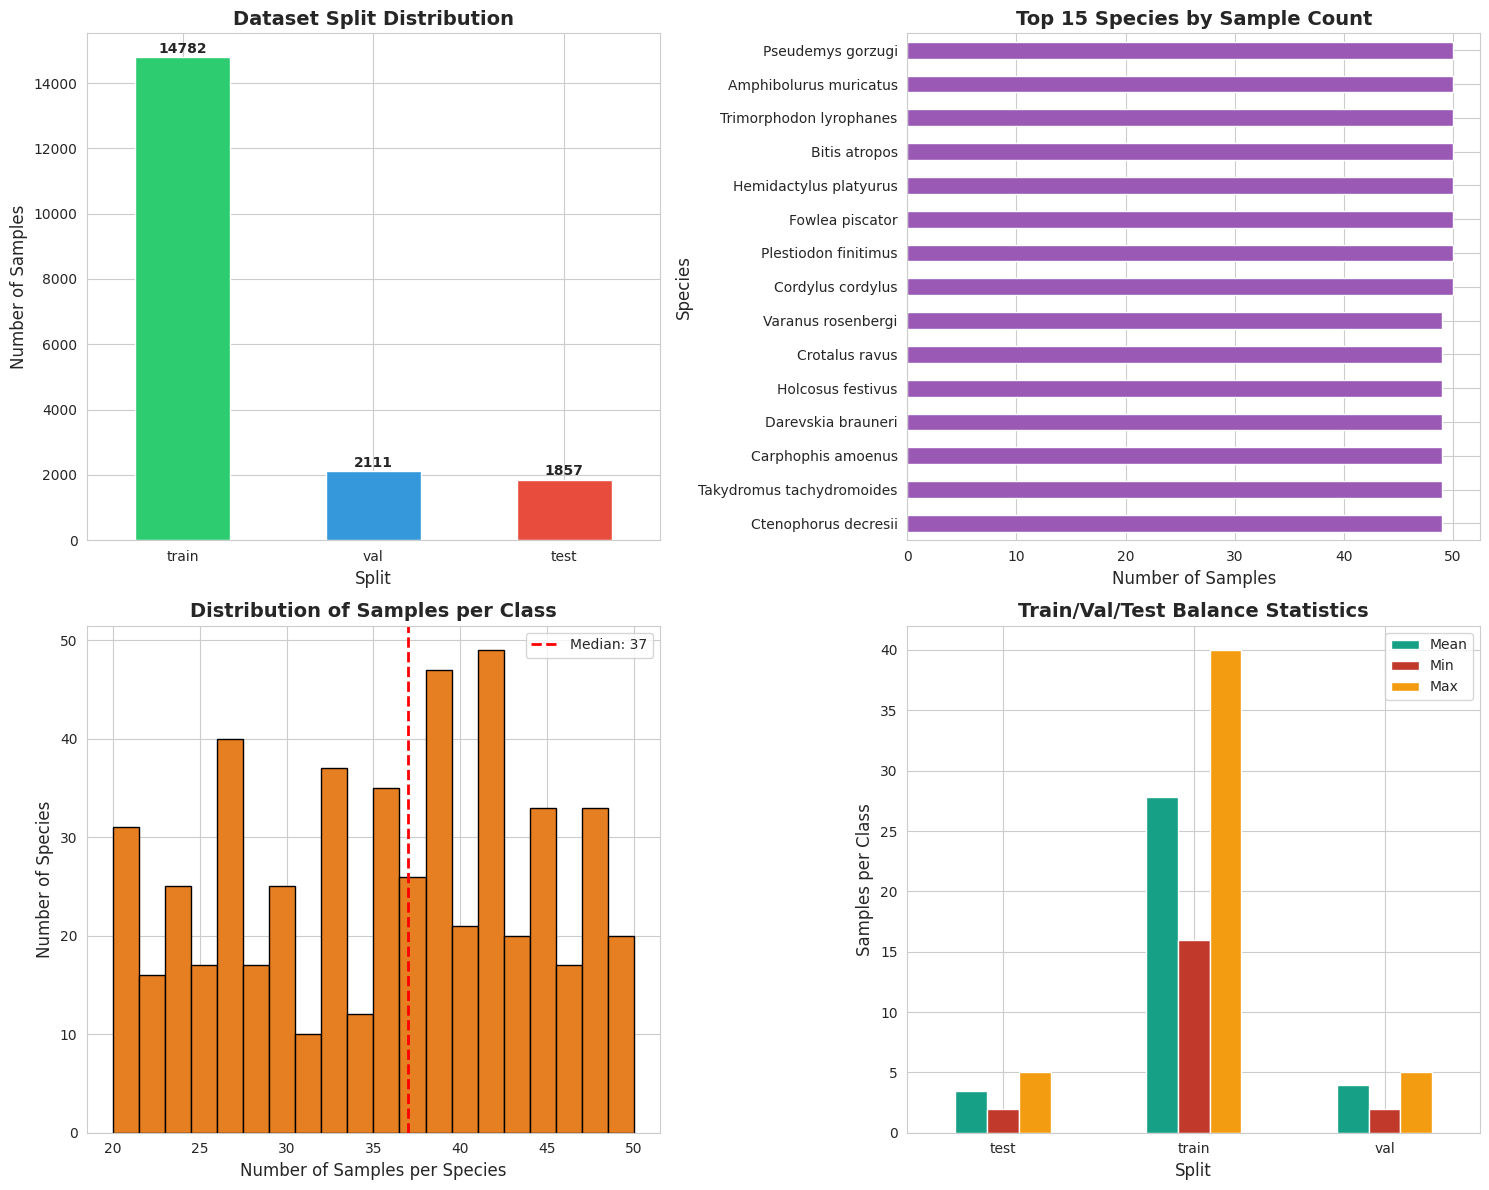

Visualization saved to: /content/drive/MyDrive/herpeton/data/biotrove_train/dataset_statistics.png


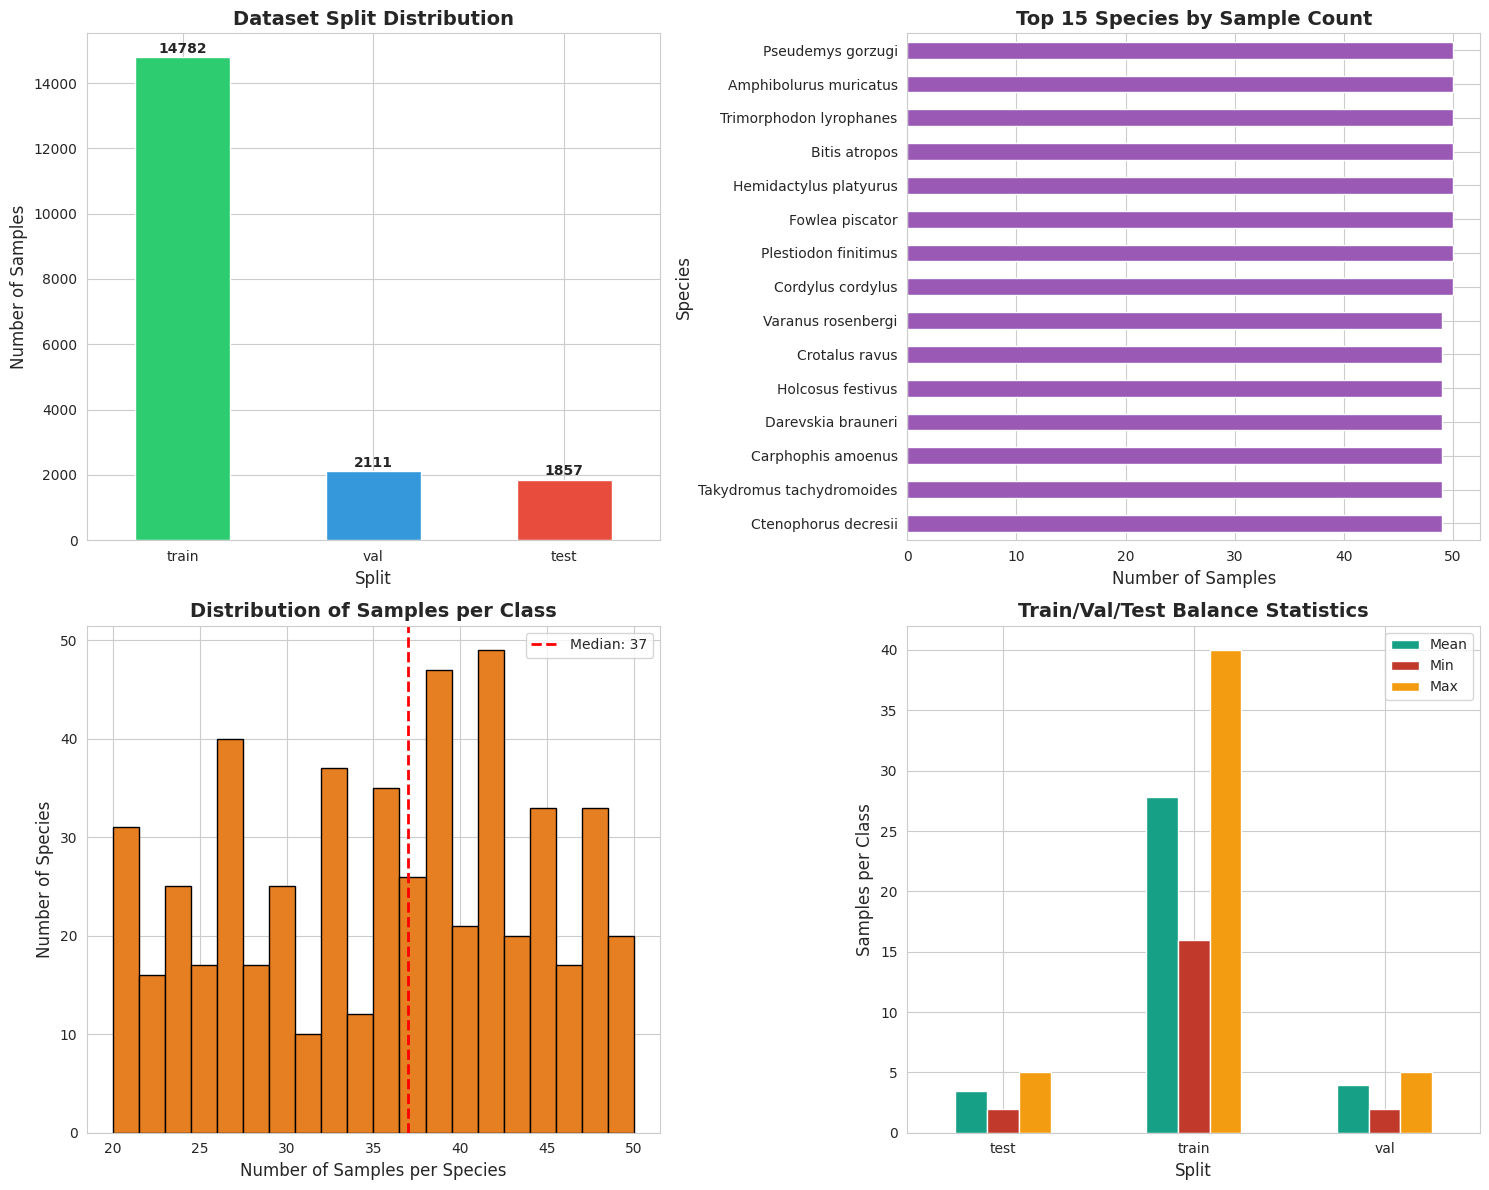

In [13]:
# Visualize dataset statistics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Split distribution
ax1 = axes[0, 0]
split_counts = meta["split"].value_counts()
split_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#3498db', '#e74c3c'])
ax1.set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Split', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.tick_params(axis='x', rotation=0)
for i, v in enumerate(split_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# 2. Top 15 species distribution
ax2 = axes[0, 1]
top_species = meta["scientificName"].value_counts().head(15)
top_species.plot(kind='barh', ax=ax2, color='#9b59b6')
ax2.set_title('Top 15 Species by Sample Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Samples', fontsize=12)
ax2.set_ylabel('Species', fontsize=12)
ax2.invert_yaxis()

# 3. Samples per class distribution
ax3 = axes[1, 0]
samples_per_class = meta["scientificName"].value_counts()
ax3.hist(samples_per_class, bins=20, color='#e67e22', edgecolor='black')
ax3.set_title('Distribution of Samples per Class', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Samples per Species', fontsize=12)
ax3.set_ylabel('Number of Species', fontsize=12)
ax3.axvline(samples_per_class.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {samples_per_class.median():.0f}')
ax3.legend()

# 4. Split balance per class (showing mean, min, max)
ax4 = axes[1, 1]
split_stats = per_class.agg(['mean', 'min', 'max'])
split_stats.T.plot(kind='bar', ax=ax4, color=['#16a085', '#c0392b', '#f39c12'])
ax4.set_title('Train/Val/Test Balance Statistics', fontsize=14, fontweight='bold')
ax4.set_xlabel('Split', fontsize=12)
ax4.set_ylabel('Samples per Class', fontsize=12)
ax4.tick_params(axis='x', rotation=0)
ax4.legend(['Mean', 'Min', 'Max'])

plt.tight_layout()
plt.savefig(DATA_ROOT / 'dataset_statistics.png', dpi=300, bbox_inches='tight')
print(f"Visualization saved to: {DATA_ROOT / 'dataset_statistics.png'}")
plt.show()

# Step 15: Save Final Dataset Metadata

In [14]:
# Save final metadata
output_metadata_path = DATA_ROOT / "reptilia_dataset_final.csv"
meta.to_csv(output_metadata_path, index=False)
print(f"Final dataset metadata saved to: {output_metadata_path}")
print(f"  Total records: {len(meta):,}")
print(f"  Columns: {', '.join(meta.columns)}")

# Create a summary file
summary = {
    "total_samples": len(meta),
    "unique_species": meta["scientificName"].nunique(),
    "train_samples": len(meta[meta["split"] == "train"]),
    "val_samples": len(meta[meta["split"] == "val"]),
    "test_samples": len(meta[meta["split"] == "test"]),
    "min_images_per_class": min_images_per_class,
    "split_ratios": split_ratios,
    "rare_threshold": 1000,
    "cap_threshold": 50,
    "processing_date": time.strftime("%Y-%m-%d %H:%M:%S")
}

summary_path = DATA_ROOT / "dataset_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Dataset summary saved to: {summary_path}")
print("\n" + "=" * 60)
print("ALL PROCESSING COMPLETE!")
print("=" * 60)
print("\nDataset is ready for training. Key files:")
print(f"  1. Metadata: {output_metadata_path}")
print(f"  2. Images: {IMG_DIR}")
print(f"  3. Summary: {summary_path}")
print(f"  4. Visualization: {DATA_ROOT / 'dataset_statistics.png'}")

Final dataset metadata saved to: /content/drive/MyDrive/herpeton/data/biotrove_train/reptilia_dataset_final.csv
  Total records: 18,750
  Columns: photo_id, scientificName, kingdom, phylum, class, order, family, genus, species, common_name, taxonRank, photo_url, split
Dataset summary saved to: /content/drive/MyDrive/herpeton/data/biotrove_train/dataset_summary.json

ALL PROCESSING COMPLETE!

Dataset is ready for training. Key files:
  1. Metadata: /content/drive/MyDrive/herpeton/data/biotrove_train/reptilia_dataset_final.csv
  2. Images: /content/drive/MyDrive/herpeton/data/biotrove_train/images_reptilia
  3. Summary: /content/drive/MyDrive/herpeton/data/biotrove_train/dataset_summary.json
  4. Visualization: /content/drive/MyDrive/herpeton/data/biotrove_train/dataset_statistics.png
Final dataset metadata saved to: /content/drive/MyDrive/herpeton/data/biotrove_train/reptilia_dataset_final.csv
  Total records: 18,750
  Columns: photo_id, scientificName, kingdom, phylum, class, order, fa